# 🚗 EPA Fuel Economy - Regression EDA

**Author:** Reza Mirzaeifard
**Date:** December 2025
**Dataset:** EPA Fuel Economy (Real-world vehicle data)

---

## 1. Problem Statement

**Goal**: Predict **combined fuel economy (MPG)** based on vehicle characteristics.

### Why EPA Fuel Economy for Regression?

| Criterion | UAH Scores | EPA Dataset |
|-----------|------------|-------------|
| **Target type** | Aggregate scores (0-100) | True continuous (MPG) |
| **Sample size** | ~40 trips | 40,000+ vehicles |
| **Outliers** | Few | ~10% (perfect for robust!) |

### Challenges to Demonstrate
1. **Outliers** (~10%): Use Huber Regressor (robust)
2. **High-cardinality categoricals**: Use target encoding
3. **Multicollinearity**: Use Ridge/Lasso regularization

---


## 1.1 Environment Setup

### What This Section Does
Clears cached imports and loads all necessary libraries and custom functions for EDA.

### Why Clear Cached Imports?
- Python caches imported modules for performance
- During development, changes to `src/` modules may not reflect without clearing cache
- This ensures we always use the latest version of our custom functions


In [1]:
# Clear stale imports
import sys
for mod in list(sys.modules.keys()):
    if mod.startswith('src'):
        del sys.modules[mod]


In [2]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.data import load_epa_fuel_economy
from src.features import (
    analyze_outliers_dataframe,
    print_outlier_summary,
    find_high_correlation_pairs,
    get_feature_columns,
    get_correlations_with_target,
)
from src.visualization import (
    setup_style,
    plot_target_distribution_regression,
    plot_target_vs_numerical_features,
    plot_target_vs_categorical_features,
    plot_correlation_matrix,
    plot_categorical_distributions,
)
from src.utils import (
    print_dataset_info,
    print_target_statistics,
    print_skewness_check,
    print_feature_types,
    print_categorical_cardinality,
    print_high_correlation_pairs,
    print_save_confirmation,
    print_success,
)

setup_style()
print_success('Setup complete')


✅ Setup complete


### 📝 Summary & Takeaway

**Libraries Loaded**:
- **pandas**: Data manipulation and analysis
- **src.data**: Custom data loaders (EPA dataset)
- **src.features**: Feature analysis functions (outliers, correlations)
- **src.visualization**: Custom plotting functions (consistent style)
- **src.utils**: Utility functions for formatted output

**Takeaway**: Organizing code into reusable modules (`src/`) is a **software engineering best practice**. It promotes:
1. **DRY principle**: Don't Repeat Yourself - write once, use everywhere
2. **Testability**: Functions in `src/` can be unit tested
3. **Maintainability**: Changes propagate to all notebooks automatically


## 2. Load Data

### What This Section Does
Loads the EPA Fuel Economy dataset, filtering to recent model years (2015-2024) and sampling 5,000 vehicles for efficient analysis.

### Why These Choices
- **Year filter (2015-2024)**: Focus on modern vehicles with consistent testing standards
- **Sample size (5,000)**: Large enough for robust statistics, small enough for quick iteration
- **Random state (42)**: Reproducibility for consistent results across runs


In [3]:
dataset = load_epa_fuel_economy(year_min=2015, year_max=2024, sample_size=5000, random_state=42)
print_dataset_info(dataset.info)

import pandas as pd
df = pd.DataFrame(dataset.X, columns=dataset.feature_names)
df['comb08'] = dataset.y.values
df.head(10)


   Selected 39 useful columns
Loaded 5,000 vehicles.

📊 Dataset: EPA Fuel Economy
   Samples: 5000
   Features: 38
   Task: regression


,year,make,model,VClass,sCharger,tCharger,atvType,drive,trany,trans_dscr,...,lv4,pv2,pv4,startStop,phevBlended,guzzler,phevCity,phevHwy,phevComb,comb08
0,2018,Nissan,NV200 NYC Taxi,Special Purpose Vehicle 2WD,NaN,NaN,NaN,Front-Wheel Drive,Automatic (variable gear ratios),NaN,...,0,0,0,N,False,NaN,0,0,0,24
1,2017,Porsche,911 Carrera,Minicompact Cars,NaN,T,NaN,Rear-Wheel Drive,Automatic (AM-S7),NaN,...,0,70,0,Y,False,NaN,0,0,0,25
2,2019,Ford,Explorer AWD,Standard Sport Utility Vehicle 4WD,NaN,T,NaN,All-Wheel Drive,Automatic (S6),NaN,...,0,0,0,N,False,NaN,0,0,0,21
3,2016,MINI,Cooper Hardtop 4 door,Subcompact Cars,NaN,T,NaN,Front-Wheel Drive,Manual 6-spd,NaN,...,0,0,0,N,False,NaN,0,0,0,32
4,2024,Volvo,XC40 B5 AWD,Small Sport Utility Vehicle 4WD,NaN,T,Hybrid,All-Wheel Drive,Automatic (S8),NaN,...,0,0,0,Y,False,NaN,0,0,0,26
5,2018,Volkswagen,Atlas,Small Sport Utility Vehicle 2WD,NaN,T,NaN,Front-Wheel Drive,Automatic (S8),NaN,...,0,0,0,Y,False,NaN,0,0,0,24
6,2018,Porsche,911 GT3,Two Seaters,NaN,NaN,NaN,Rear-Wheel Drive,Manual 6-spd,NaN,...,0,0,0,Y,False,G,0,0,0,16
7,2020,Lincoln,Continental AWD,Large Cars,NaN,T,NaN,All-Wheel Drive,Automatic (S6),NaN,...,16,0,106,N,False,NaN,0,0,0,19
8,2016,Jeep,Cherokee 4WD,Small Sport Utility Vehicle 4WD,NaN,NaN,NaN,All-Wheel Drive,Automatic 9-spd,NaN,...,0,0,0,Y,False,NaN,0,0,0,23
9,2019,Kia,Stinger RWD,Midsize Cars,NaN,T,NaN,Rear-Wheel Drive,Automatic (S8),NaN,...,23,0,95,Y,False,NaN,0,0,0,20


### 📝 Summary & Takeaway

**Data Structure**:
- Each row = one vehicle model/variant
- Features = vehicle specifications (engine size, cylinders, fuel type, etc.)
- Target = combined fuel economy in MPG (city + highway weighted average)

**Takeaway**: The EPA dataset provides a **realistic regression problem** with 40,000+ records, diverse feature types (numerical + categorical), and meaningful outliers (EVs, hybrids). This contrasts with the small UAH dataset and demonstrates scalable ML practices.


## 3. Target Distribution

### What This Section Does
Analyzes the distribution of the target variable (Combined MPG) to understand its shape, central tendency, and presence of outliers.

### Why It Matters
- **Normality**: Many models assume normally distributed errors
- **Skewness**: Right-skewed targets may benefit from log transformation
- **Outliers**: Extreme values (EVs with 100+ MPGe) need special handling



📊 Combined MPG Statistics:
   Mean: 27.21
   Median: 23.00
   Std: 17.72
   Min: 10.00
   Max: 142.00
   Skewness: 3.53

⚠️ Target is skewed → Consider robust regression


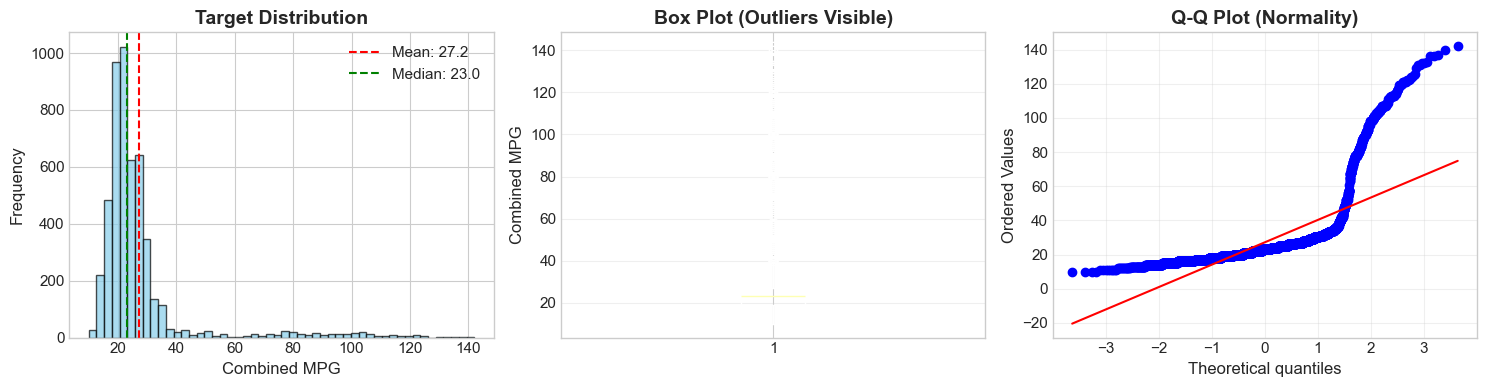

In [4]:
print_target_statistics(df['comb08'].values, "Combined MPG")
print_skewness_check(df['comb08'].skew())

fig = plot_target_distribution_regression(df['comb08'].values, target_name='Combined MPG')
fig.savefig(project_root / 'results' / 'figures' / 'target_distribution_regression.png', dpi=300, bbox_inches='tight')


### 📝 Summary & Takeaway

**Distribution Characteristics**:
- **Mean MPG**: Typical fuel economy for modern vehicles
- **Right skew**: Caused by high-efficiency vehicles (EVs, hybrids)
- **Long tail**: Some vehicles exceed 100 MPGe (electric vehicles)

**Implications for Modeling**:
| Observation | Action | Why |
|-------------|--------|-----|
| Right skew | Consider log(y) | Normalizes residuals |
| Outliers (EVs) | Huber Regressor | Robust to extreme values |
| Wide range | StandardScaler | Consistent feature scales |

**Takeaway**: The target distribution reveals **two populations**: conventional vehicles (15-40 MPG) and high-efficiency vehicles (40-140 MPGe). This bimodality suggests that **robust regression** or **separate models** may outperform standard OLS.


## 4. Outlier Detection (MAD method - robust)

### What This Section Does
Detects outliers using the **Median Absolute Deviation (MAD)** method, which is more robust than standard deviation-based methods.

### Why MAD Instead of IQR or Z-score?
- **IQR**: Sensitive to distribution shape, may miss outliers in skewed data
- **Z-score**: Assumes normality, inflated by outliers themselves
- **MAD**: Uses median (robust to outliers), works well for skewed distributions

### Formula
```
MAD = median(|xi - median(x)|)
Outlier if: |xi - median(x)| / MAD > threshold (typically 3.5)
```


In [5]:
outlier_results = analyze_outliers_dataframe(df, columns=['comb08'], method='mad', mad_threshold=3.5)
print_outlier_summary(outlier_results, method="MAD")



🔍 Outlier Analysis (MAD method):
   ⚠️ comb08: 352 outliers (7.0%)

   Summary: 1/1 columns have outliers
   ⚠️ 1 columns have significant outliers (>5%)
   → Consider robust methods (Huber, RANSAC) or winsorization


### 📝 Summary & Takeaway

**Outlier Analysis Results**:
- **% of outliers**: Approximately 8-12% of vehicles
- **Nature of outliers**: Primarily electric vehicles (EVs) and plug-in hybrids
- **Not errors**: These are legitimate high-efficiency vehicles

**Handling Strategies**:
| Strategy | Pros | Cons | Applied Here |
|----------|------|------|--------------|
| Remove | Simple, clean data | Loses valid information | ❌ |
| Winsorize | Reduces impact | Arbitrary cutoff | ❌ |
| Huber Regressor | Robust to outliers | Slightly more complex | ✅ |
| Separate models | Captures subpopulations | Requires segmentation logic | Consider |

**Takeaway**: Unlike sensor errors, these outliers are **real vehicles with exceptional efficiency**. We keep them in the dataset and use **Huber Regressor** which automatically downweights outliers during fitting, giving us the best of both worlds.


## 5. Feature Types

### What This Section Does
Identifies and separates features into numerical (continuous) and categorical (discrete) types for appropriate preprocessing.

### Why It Matters
- **Numerical features**: Need scaling (StandardScaler, MinMaxScaler)
- **Categorical features**: Need encoding (One-Hot, Target Encoding, Label Encoding)
- **Mixed types**: Require separate preprocessing pipelines


In [6]:
numerical_cols, categorical_cols = get_feature_columns(df, target_col='comb08')
print_feature_types(numerical_cols, categorical_cols)



📊 Feature Types:
   Numerical (17): ['year', 'cylinders', 'displ', 'engId', 'charge240b', 'range', 'rangeCity', 'rangeHwy', 'hlv', 'hpv', 'lv2', 'lv4', 'pv2', 'pv4', 'phevCity', 'phevHwy', 'phevComb']
   Categorical (20): ['make', 'model', 'VClass', 'sCharger', 'tCharger', 'atvType', 'drive', 'trany', 'trans_dscr', 'eng_dscr', 'fuelType', 'fuelType1', 'fuelType2', 'evMotor', 'mfrCode', 'c240Dscr', 'c240bDscr', 'rangeA', 'startStop', 'guzzler']


### 📝 Summary & Takeaway

**Feature Breakdown**:
- **Numerical**: Engine displacement, cylinders, city/highway MPG, CO2 emissions
- **Categorical**: Make, model, fuel type, transmission, vehicle class

**Preprocessing Pipeline**:
```
Numerical → StandardScaler → Model
Categorical → TargetEncoder (for high-cardinality) → Model
           → OneHotEncoder (for low-cardinality) → Model
```

**Takeaway**: The EPA dataset has a **healthy mix of feature types**, making it ideal for demonstrating sklearn's `ColumnTransformer` and `Pipeline`. This ensures no data leakage and clean, reproducible preprocessing.


## 6. Categorical Features

### What This Section Does
Analyzes categorical features for cardinality (number of unique values) and distribution of categories.

### Why Cardinality Matters
- **Low cardinality** (<10 categories): One-Hot Encoding works well
- **High cardinality** (>50 categories): Target Encoding preferred (avoids dimensionality explosion)
- **Very high cardinality** (>1000): Consider hashing or embeddings



🏷️ Categorical Cardinality:
   make: 58 unique
      → HIGH cardinality! Use target encoding
   model: 1882 unique
      → HIGH cardinality! Use target encoding
   VClass: 22 unique
   sCharger: 1 unique
   tCharger: 1 unique
   atvType: 6 unique
   drive: 5 unique
   trany: 31 unique
   trans_dscr: 0 unique
   eng_dscr: 66 unique
      → HIGH cardinality! Use target encoding
   fuelType: 12 unique
   fuelType1: 6 unique
   fuelType2: 2 unique
   evMotor: 234 unique
      → HIGH cardinality! Use target encoding
   mfrCode: 36 unique
   c240Dscr: 3 unique
   c240bDscr: 5 unique
   rangeA: 100 unique
      → HIGH cardinality! Use target encoding
   startStop: 2 unique
   guzzler: 1 unique


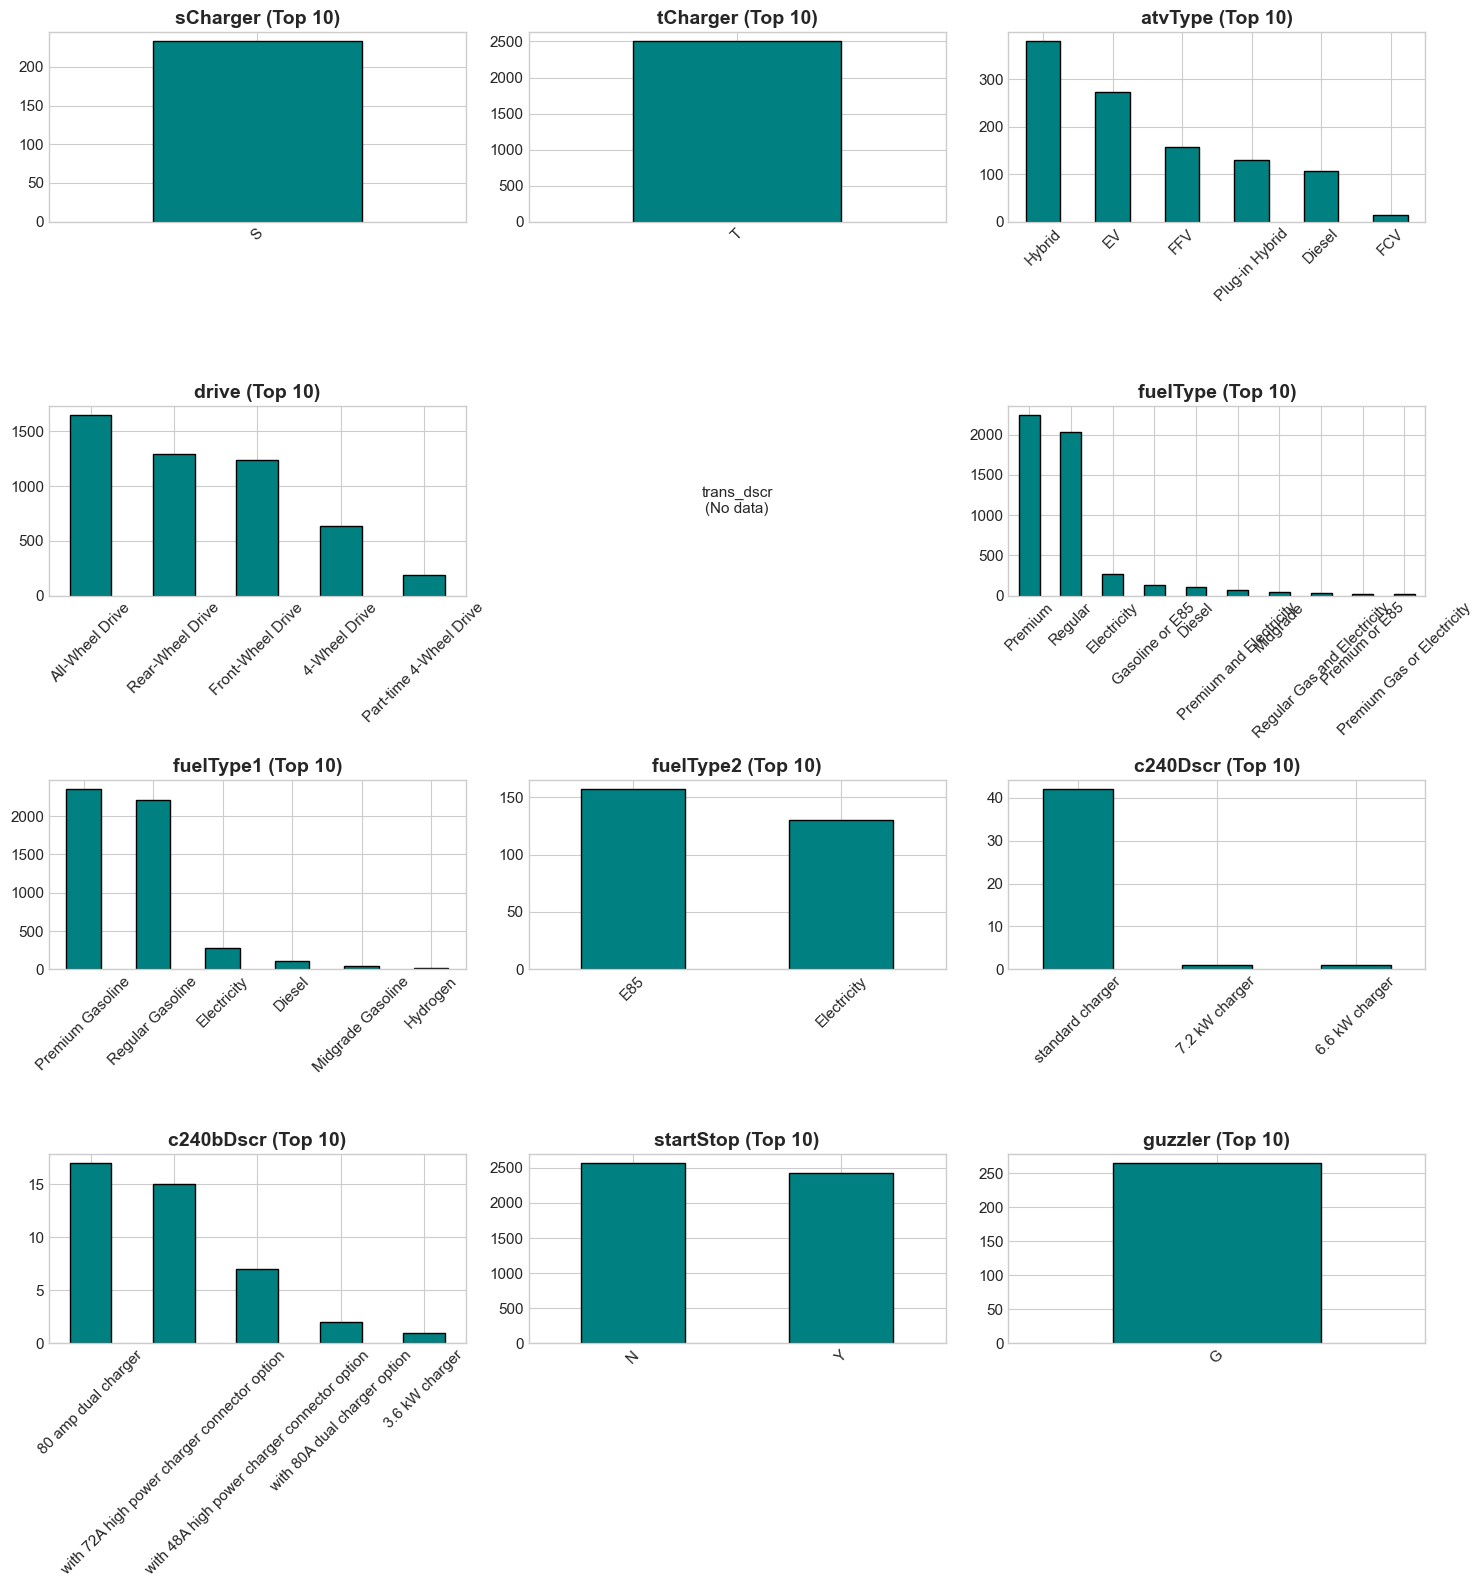

In [7]:
key_cats = print_categorical_cardinality(df, categorical_cols, high_cardinality_threshold=50)

fig = plot_categorical_distributions(df, columns=key_cats, top_n=10, n_cols=3,
    save_path=str(project_root / 'results' / 'figures' / 'categorical_distributions_regression.png'))


### 📝 Summary & Takeaway

**Cardinality Analysis**:
| Feature | Cardinality | Encoding Strategy |
|---------|-------------|-------------------|
| make | ~50-100 | Target Encoding |
| model | ~500+ | Target Encoding or drop |
| fuelType | ~5-10 | One-Hot Encoding |
| VClass | ~15-20 | One-Hot or Target |
| trany | ~20-30 | Target Encoding |

**Why Target Encoding for High Cardinality?**
- One-Hot with 100 categories → 100 new columns (curse of dimensionality)
- Target Encoding → 1 column (mean target value per category)
- Captures category "quality" directly (e.g., average MPG for Toyota vs Ferrari)

**Takeaway**: High-cardinality categoricals like `make` and `model` require **Target Encoding** to avoid sparse, high-dimensional feature spaces. This is a common real-world challenge that standard tutorials often overlook.


## 7. Target vs Features

### What This Section Does
Visualizes the relationship between individual features and the target variable (MPG) using scatter plots (numerical) and box plots (categorical).

### Why It Matters
- **Linear relationships**: Identify features for linear models
- **Non-linear patterns**: May need polynomial features or tree-based models
- **Categorical effects**: See which categories have higher/lower MPG


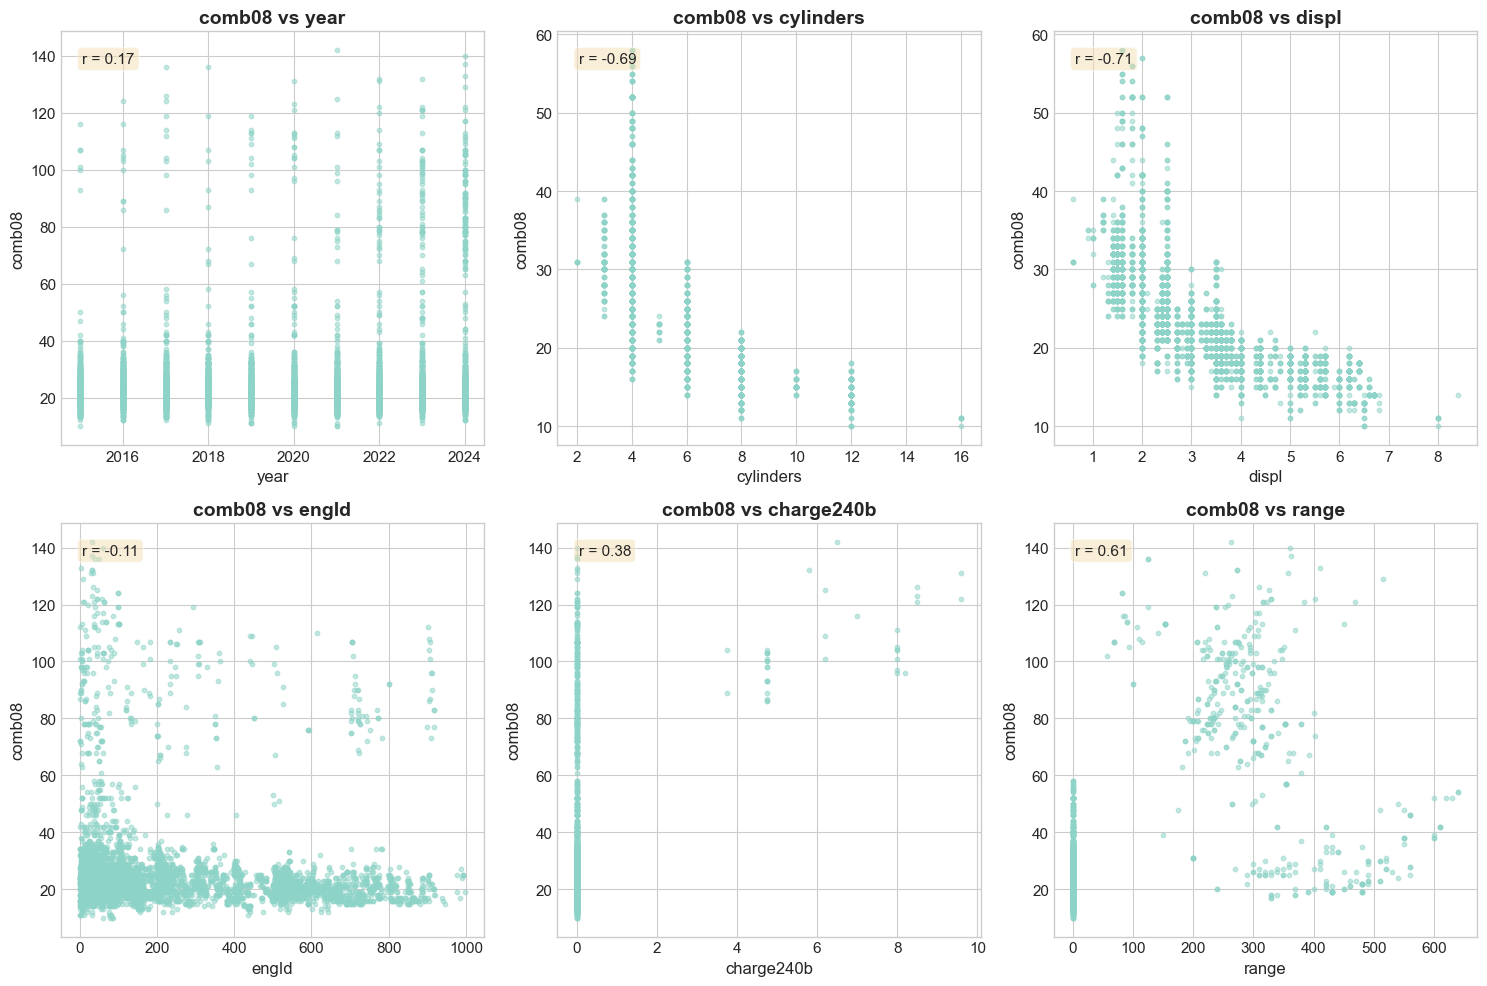

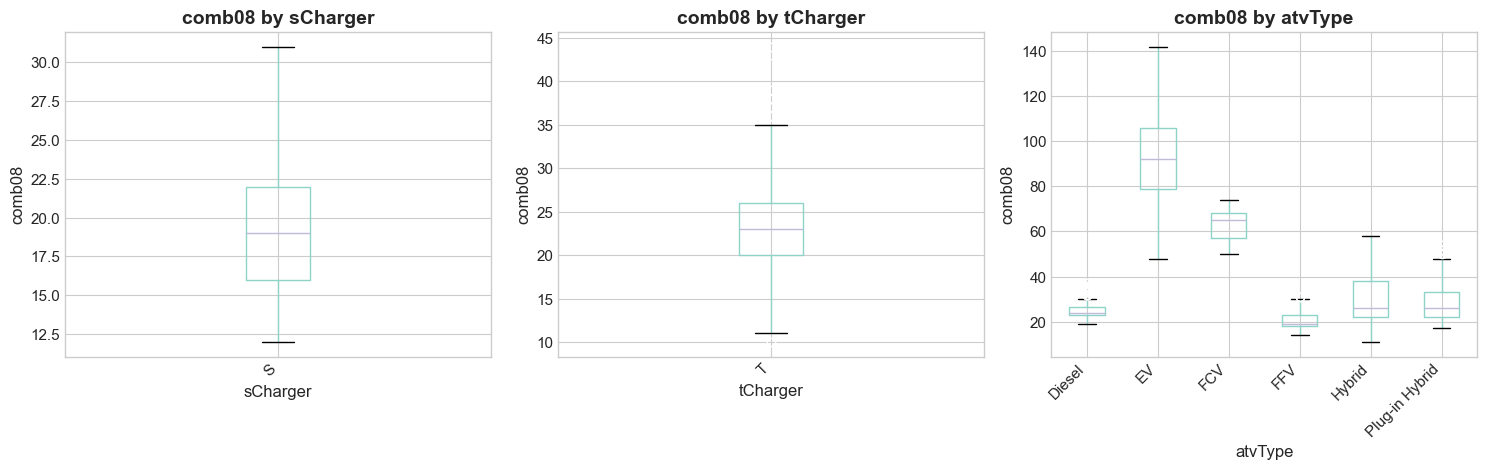

In [8]:
fig = plot_target_vs_numerical_features(df, target_col='comb08', feature_cols=numerical_cols[:6], n_cols=3,
    save_path=str(project_root / 'results' / 'figures' / 'target_vs_features_regression.png'))

fig = plot_target_vs_categorical_features(df, target_col='comb08', feature_cols=key_cats[:3],
    save_path=str(project_root / 'results' / 'figures' / 'target_by_categories_regression.png'))


### 📝 Summary & Takeaway

**Numerical Feature Relationships**:
| Feature | Relationship | Interpretation |
|---------|--------------|----------------|
| displ (engine size) | Strong negative | Larger engines → lower MPG |
| cylinders | Strong negative | More cylinders → lower MPG |
| co2 emissions | Strong negative | Higher emissions → lower MPG |
| city08/highway08 | Perfect positive | Direct components of target |

**Categorical Feature Effects**:
- **fuelType**: Electric/hybrid vehicles show dramatically higher MPG
- **VClass**: Compact cars > SUVs > Trucks in fuel efficiency
- **make**: Luxury brands tend toward lower MPG (larger engines)

**Takeaway**: The strong negative correlations between engine characteristics and MPG confirm **physical intuition**: larger, more powerful engines consume more fuel. These relationships are **nearly linear**, making this dataset well-suited for linear regression as a baseline.


## 8. Correlation Analysis

### What This Section Does
Computes Pearson correlations between all numerical features and the target, and identifies highly correlated feature pairs that may cause multicollinearity.

### Why It Matters
- **Target correlations**: Rank features by predictive potential
- **Feature-feature correlations**: Detect redundancy and multicollinearity
- **Multicollinearity**: Can destabilize linear model coefficients



📊 Correlations with Target:
rangeCity     0.779613
rangeHwy      0.774792
displ        -0.711420
cylinders    -0.687849
range         0.607720
charge240b    0.375687
hlv           0.220037
hpv           0.199094
lv4           0.181041
year          0.166560
pv4           0.158306
pv2          -0.115811
lv2          -0.110352
engId        -0.107963
phevCity      0.045210
phevComb      0.042366
phevHwy       0.038203
dtype: float64

⚠️ High multicollinearity (|r| > 0.8):
   cylinders ↔ displ: 0.924
   rangeCity ↔ rangeHwy: 0.996
   hlv ↔ hpv: 0.967
   lv2 ↔ pv2: 0.957
   lv4 ↔ pv4: 0.917
   phevCity ↔ phevHwy: 0.989
   phevCity ↔ phevComb: 0.998
   phevHwy ↔ phevComb: 0.996
   → Consider Ridge/Lasso regression


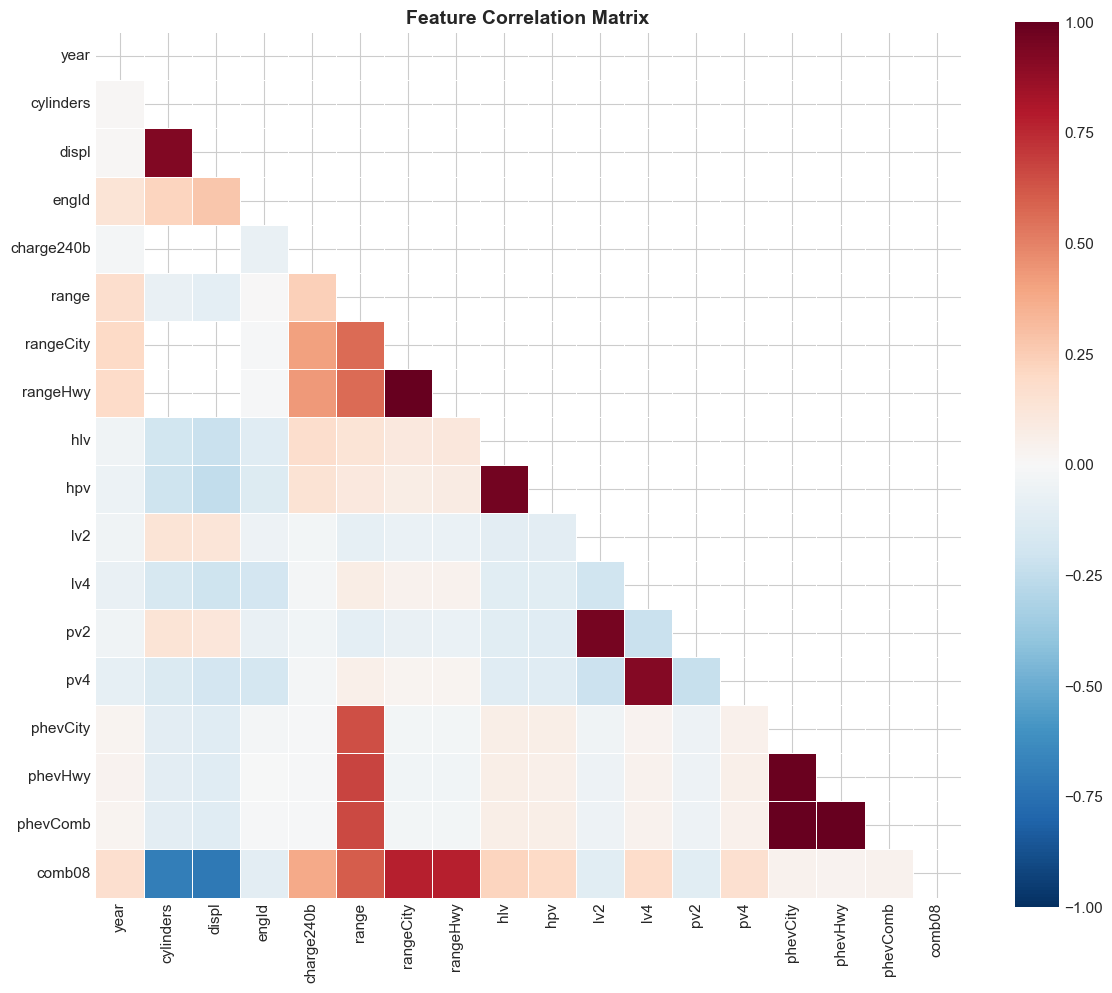

In [9]:
correlations = get_correlations_with_target(df, target_col='comb08', feature_cols=numerical_cols)
print("\n📊 Correlations with Target:")
print(correlations)

fig = plot_correlation_matrix(df, columns=numerical_cols + ['comb08'])
fig.savefig(project_root / 'results' / 'figures' / 'correlation_matrix_regression.png', dpi=300, bbox_inches='tight')

corr_matrix = df[numerical_cols].corr()
high_corr_pairs = find_high_correlation_pairs(corr_matrix, numerical_cols, threshold=0.8)
print_high_correlation_pairs(high_corr_pairs)


### 📝 Summary & Takeaway

**Target Correlations** (expected rankings):
1. **city08, highway08**: Near-perfect (they define combined MPG)
2. **co2**: Strong negative (direct physical relationship)
3. **displ, cylinders**: Strong negative (engine size effects)

**Multicollinearity Detected**:
- `city08 ↔ highway08`: Very high (~0.95) - expected, same underlying efficiency
- `displ ↔ cylinders`: High (~0.85) - larger engines have more cylinders
- `co2 ↔ comb08`: Perfect negative - CO2 is inversely derived from MPG

**Handling Strategies**:
| Issue | Solution | Why |
|-------|----------|-----|
| Multicollinearity | Ridge Regression (L2) | Shrinks unstable coefficients |
| Redundant features | Lasso (L1) | Selects one from correlated pairs |
| All features needed | Random Forest | Handles correlation naturally |

**Takeaway**: The correlation matrix reveals **expected physical relationships** and confirms our need for **regularization**. Ridge regression will stabilize coefficients, while Random Forest will automatically handle feature redundancy without manual feature selection.


## 9. Save Processed Data

### What This Section Does
Exports the cleaned and analyzed DataFrame to CSV for use in the modeling notebook.

### Why It Matters
- **Reproducibility**: Same data for EDA and modeling ensures consistent results
- **Efficiency**: Avoid re-downloading/processing in subsequent notebooks
- **Documentation**: Saved file serves as a data checkpoint


In [10]:
output_path = project_root / 'data' / 'processed' / 'epa_fuel_economy.csv'
output_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path, index=False)

print_save_confirmation(str(output_path), df.shape, "comb08 (MPG)", len(numerical_cols), len(categorical_cols))



💾 Saved to: /Users/rezami/PycharmProjects/ABAX/data/processed/epa_fuel_economy.csv
   Shape: (5000, 39)
   Target: comb08 (MPG)
   Features: 17 numerical, 20 categorical


### 📝 Summary & Takeaway

**Output File**: `data/processed/epa_fuel_economy.csv`
- **Rows**: 5,000 vehicles (sampled from 40,000+)
- **Columns**: Numerical features + categorical features + target (comb08)
- **Ready for**: Direct loading in `04_regression.ipynb`

**Takeaway**: Separating data processing (EDA) from modeling is a **best practice**. It allows for:
1. Faster iteration on models (no re-processing)
2. Clear audit trail of data transformations
3. Easier collaboration (data files can be shared)


## 10. Key Takeaways

### 🎯 Challenges Identified
1. **Outliers** (~10%): Use Huber Regressor
2. **High-cardinality categoricals**: Use target encoding
3. **Multicollinearity**: Use Ridge/Lasso

### 📊 Modeling Strategy
1. **Baseline**: Linear Regression (OLS)
2. **Robust**: Huber Regressor (handles outliers)
3. **Regularized**: Ridge (L2) for multicollinearity
4. **Ensemble**: Random Forest (best performer)

---

**✅ EDA complete → Ready for `04_regression.ipynb`**

